# ctDNA variant analysis for patient CTC347

This notebook reproduces the main steps as described in the README  

* Load Mutect2 VCFs for pre and post treatment ctDNA  
* Build simple variant keys to compare the two time points  
* Quantify shared, lost, and gained variants  
* Focus on the KRAS locus as a gene of interest  
* Visualize variant dynamics and interpret them in the context of anti EGFR therapy


In [1]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
from pathlib import Path
import os
dir = Path("/content/drive/MyDrive/CTC347")
results_dir =dir
os.chdir(results_dir)
list(results_dir.iterdir())


[PosixPath('/content/drive/MyDrive/CTC347/SRR13973720.vcf.gz'),
 PosixPath('/content/drive/MyDrive/CTC347/SRR13973720.vcf.gz.tbi'),
 PosixPath('/content/drive/MyDrive/CTC347/SRR13973720.vcf.gz.stats'),
 PosixPath('/content/drive/MyDrive/CTC347/SRR13973721.vcf.gz.tbi'),
 PosixPath('/content/drive/MyDrive/CTC347/SRR13973721.vcf.gz'),
 PosixPath('/content/drive/MyDrive/CTC347/SRR13973721.vcf.gz.stats'),
 PosixPath('/content/drive/MyDrive/CTC347/post.txt'),
 PosixPath('/content/drive/MyDrive/CTC347/pre.keys'),
 PosixPath('/content/drive/MyDrive/CTC347/post.keys'),
 PosixPath('/content/drive/MyDrive/CTC347/pre.txt'),
 PosixPath('/content/drive/MyDrive/CTC347/pre.u.txt'),
 PosixPath('/content/drive/MyDrive/CTC347/post.u.txt'),
 PosixPath('/content/drive/MyDrive/CTC347/shared.txt'),
 PosixPath('/content/drive/MyDrive/CTC347/lost_after_treatment.txt'),
 PosixPath('/content/drive/MyDrive/CTC347/gained_after_treatment.txt'),
 PosixPath('/content/drive/MyDrive/CTC347/pre.sorted'),
 PosixPath('/co

## Generating variant keys

Each variant is reduced to a simple key:
`CHROM   POS   REF   ALT`

This collapses VCF line differences (INFO, FORMAT fields) into the true biological variant, and ensures consistent comparison between samples.


In [3]:
import gzip

pre_vcf = results_dir / "SRR13973720.vcf.gz"
post_vcf = results_dir / "SRR13973721.vcf.gz"

pre_keys_path = results_dir / "pre.keys"
post_keys_path = results_dir / "post.keys"

def vcf_keys(vcf_gz_path: Path, keys_path: Path):
    keys = []
    with gzip.open(vcf_gz_path, "rt") as fin:
        for line in fin:
            if line.startswith("#"):
                continue
            fields = line.rstrip("\n").split("\t")
            if len(fields) < 5:
                continue
            chrom = fields[0]
            pos   = fields[1]
            ref   = fields[3]
            alt   = fields[4]
            key = "\t".join([chrom, pos, ref, alt])
            keys.append(key)
    keys = sorted(set(keys))
    with keys_path.open("w") as fout:
        for k in keys:
            fout.write(k + "\n")
    print(f"Wrote {len(keys)} keys → {keys_path.name}")

if not pre_keys_path.exists():
    vcf_keys(pre_vcf, pre_keys_path)
else:
    print("pre.keys already exists")

if not post_keys_path.exists():
    vcf_keys(post_vcf, post_keys_path)
else:
    print("post.keys already exists")


pre.keys already exists
post.keys already exists


Create unique sorted versions and load the keys

In [4]:
def total_keys(path: Path):
    with path.open() as f:
        return [ln.strip() for ln in f if ln.strip()]

pre_keys = total_keys(pre_keys_path)
post_keys = total_keys(post_keys_path)

pre_set = set(pre_keys)
post_set = set(post_keys)

shared_set = pre_set & post_set
lost_set   = pre_set - post_set
gained_set = post_set - pre_set

print("Variant Key Summary")
print("-------------------")
print(f"Pre-treatment keys:   {len(pre_set):8d}")
print(f"Post-treatment keys:  {len(post_set):8d}")
print(f"Shared:               {len(shared_set):8d}")
print(f"Lost after treatment: {len(lost_set):8d}")
print(f"Gained after:         {len(gained_set):8d}")


Variant Key Summary
-------------------
Pre-treatment keys:      14701
Post-treatment keys:    421481
Shared:                   3554
Lost after treatment:    11147
Gained after:           417927


Write Comparison Files

In [5]:
def lines(lines, path: Path):
    with path.open("w") as f:
        for ln in sorted(lines):
            f.write(ln + "\n")

pre_sorted_path   = results_dir / "pre.sorted"
post_sorted_path  = results_dir / "post.sorted"
shared_keys_path  = results_dir / "shared.keys"
lost_keys_path    = results_dir / "lost_after_treatment.keys"
gained_keys_path  = results_dir / "gained_after_treatment.keys"

lines(pre_set, pre_sorted_path)
lines(post_set, post_sorted_path)
lines(shared_set, shared_keys_path)
lines(lost_set, lost_keys_path)
lines(gained_set, gained_keys_path)

for p in [pre_sorted_path, post_sorted_path, shared_keys_path,
          lost_keys_path, gained_keys_path]:
    print(f"{sum(1 for _ in open(p)):8d}  {p.name}")


   14701  pre.sorted
  421481  post.sorted
    3554  shared.keys
   11147  lost_after_treatment.keys
  417927  gained_after_treatment.keys


## Global Variant Visualization:
To visualize how the mutation landscape shifts between timepoints,  
we plot the number of variants that are:
- unique to pre  
- shared  
- unique to post


Bar Plot for Global Variant Dynamics

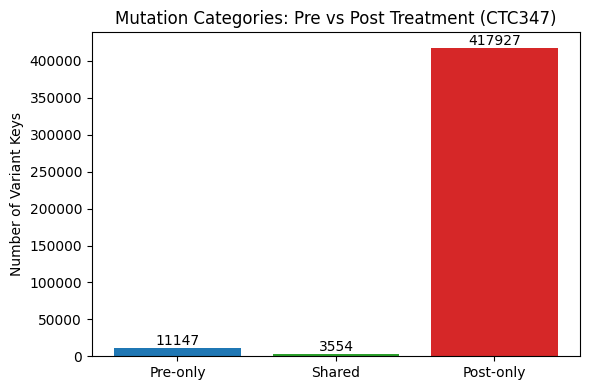

In [6]:
import matplotlib.pyplot as plt

categories = ["Pre-only", "Shared", "Post-only"]
values = [len(lost_set), len(shared_set), len(gained_set)]

plt.figure(figsize=(6,4))
plt.bar(categories, values, color=["#1f77b4", "#2ca02c", "#d62728"])
plt.title("Mutation Categories: Pre vs Post Treatment (CTC347)")
plt.ylabel("Number of Variant Keys")

for x, v in zip(categories, values):
    plt.text(x, v, str(v), ha="center", va="bottom")

plt.tight_layout()
plt.show()


KRAS Analysis Section


## KRAS Gene-Focused Variant Analysis
KRAS is a critical resistance gene in anti-EGFR–treated colorectal cancer.
The goal here is to:
- extract KRAS locus variants,
- compute allele fractions,
- classify each variant as shared,lost and gained,
- visualize allele fraction shifts.


Extract KRAS Variants

In [7]:
from dataclasses import dataclass
from typing import List, Dict
KRAS_OPTIONS = ["12", "chr12"]
KRAS_START = 25205246
KRAS_END   = 25250936

@dataclass
class Variant:
    source: str
    chrom: str
    pos: int
    ref: str
    alt: str
    af: float | None
    dp: int | None
    key: str

def read_kras(vcf_path: Path, sample_type: str):
    variants = []
    with gzip.open(vcf_path, "rt") as fin:
        for ln in fin:
            if ln.startswith("#"):
                continue
            f = ln.strip().split("\t")
            chrom, pos, _, ref, alt, _, _, _, fmt, sample = f[:10]
            if chrom not in KRAS_OPTIONS:
                continue
            pos = int(pos)
            if not (KRAS_START <= pos <= KRAS_END):
                continue

            fmt_keys = fmt.split(":")
            sample_vals = sample.split(":")
            d = dict(zip(fmt_keys, sample_vals))

            af = float(d.get("AF", "nan").split(",")[0]) if "AF" in d else None
            dp = int(d["DP"]) if "DP" in d else None

            key = f"{chrom}\t{pos}\t{ref}\t{alt}"

            variants.append(Variant(sample_type, chrom, pos, ref, alt, af, dp, key))
    return variants

pre_kras  = read_kras(pre_vcf, "pre")
post_kras = read_kras(post_vcf, "post")

len(pre_kras), len(post_kras)


(0, 11)

Build KRAS Table + Join Status

In [8]:
import pandas as pd

kras_all = pd.DataFrame([v.__dict__ for v in (pre_kras + post_kras)])

if kras_all.empty:
    print("No KRAS variants detected.")
else:
    def classify(key):
        if key in shared_set: return "shared"
        if key in lost_set:   return "lost"
        if key in gained_set: return "gained"
        return "other"

    kras_all["status"] = kras_all["key"].apply(classify)
    kras_all["label"] = (
        kras_all["chrom"] + ":" + kras_all["pos"].astype(str)
        + " " + kras_all["ref"] + ">" + kras_all["alt"]
    )

kras_all


,source,chrom,pos,ref,alt,af,dp,key,status,label
0,post,chr12,25205894,T,G,0.750,3,chr12\t25205894\tT\tG,gained,chr12:25205894 T>G
1,post,chr12,25206009,T,C,0.667,1,chr12\t25206009\tT\tC,gained,chr12:25206009 T>C
2,post,chr12,25206035,T,G,0.667,1,chr12\t25206035\tT\tG,gained,chr12:25206035 T>G
3,post,chr12,25207204,T,C,0.750,4,chr12\t25207204\tT\tC,gained,chr12:25207204 T>C
4,post,chr12,25209531,G,A,0.684,1,chr12\t25209531\tG\tA,gained,chr12:25209531 G>A
5,post,chr12,25209618,A,C,0.937,13,chr12\t25209618\tA\tC,gained,chr12:25209618 A>C
6,post,chr12,25214904,A,C,0.750,2,chr12\t25214904\tA\tC,gained,chr12:25214904 A>C
7,post,chr12,25215659,AT,"A,ATT",0.249,127,"chr12\t25215659\tAT\tA,ATT",gained,"chr12:25215659 AT>A,ATT"
8,post,chr12,25219261,T,C,0.667,2,chr12\t25219261\tT\tC,gained,chr12:25219261 T>C
9,post,chr12,25219336,AT,A,0.667,1,chr12\t25219336\tAT\tA,gained,chr12:25219336 AT>A


Pivot Pre vs Post AF

In [9]:
if kras_all.empty:
    kras_af = pd.DataFrame()
else:
    kras_af = kras_all.pivot_table(
        index=["key", "label"],
        columns="source",
        values="af",
        aggfunc="max"
    ).reset_index()
    if "pre" not in kras_af.columns:  kras_af["pre"] = None
    if "post" not in kras_af.columns: kras_af["post"] = None

    kras_af = kras_af.rename(columns={"pre": "pre_AF", "post": "post_AF"})

kras_af


source,key,label,post_AF,pre_AF
0,chr12\t25205894\tT\tG,chr12:25205894 T>G,0.750,None
1,chr12\t25206009\tT\tC,chr12:25206009 T>C,0.667,None
2,chr12\t25206035\tT\tG,chr12:25206035 T>G,0.667,None
3,chr12\t25207204\tT\tC,chr12:25207204 T>C,0.750,None
4,chr12\t25209531\tG\tA,chr12:25209531 G>A,0.684,None
5,chr12\t25209618\tA\tC,chr12:25209618 A>C,0.937,None
6,chr12\t25214904\tA\tC,chr12:25214904 A>C,0.750,None
7,"chr12\t25215659\tAT\tA,ATT","chr12:25215659 AT>A,ATT",0.249,None
8,chr12\t25219261\tT\tC,chr12:25219261 T>C,0.667,None
9,chr12\t25219336\tAT\tA,chr12:25219336 AT>A,0.667,None


KRAS AF Plot (Pre vs Post)

/tmp/ipython-input-3598475803.py:11: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pre_vals  = kras_af["pre_AF"].fillna(0).to_numpy()


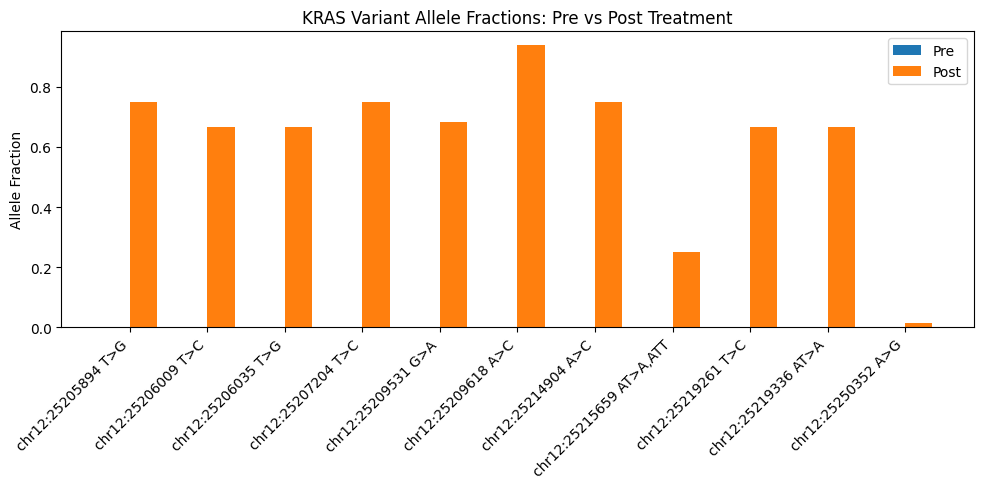

In [10]:
import numpy as np
import matplotlib.pyplot as plt

if kras_af.empty:
    print("No KRAS variants to plot.")
else:
    labels = kras_af["label"].tolist()
    x = np.arange(len(labels))
    width = 0.35

    pre_vals  = kras_af["pre_AF"].fillna(0).to_numpy()
    post_vals = kras_af["post_AF"].fillna(0).to_numpy()

    plt.figure(figsize=(10,5))
    plt.bar(x - width/2, pre_vals,  width, label="Pre")
    plt.bar(x + width/2, post_vals, width, label="Post")

    plt.xticks(x, labels, rotation=45, ha="right")
    plt.ylabel("Allele Fraction")
    plt.title("KRAS Variant Allele Fractions: Pre vs Post Treatment")
    plt.legend()
    plt.tight_layout()
    plt.show()


**Figure: KRAS variant allele fractions in ctDNA before and after treatment.**  
Each bar represents a KRAS locus mutation in patient CTC347. Blue bars indicate the pre treatment sample and orange bars indicate the post treatment sample. No KRAS variants are detected before therapy, whereas multiple variants appear after therapy with high allele fractions, indicating that KRAS mutant clones became a major fraction of the circulating tumor DNA following anti EGFR treatment.

KRAS Genomic Scatter Plot

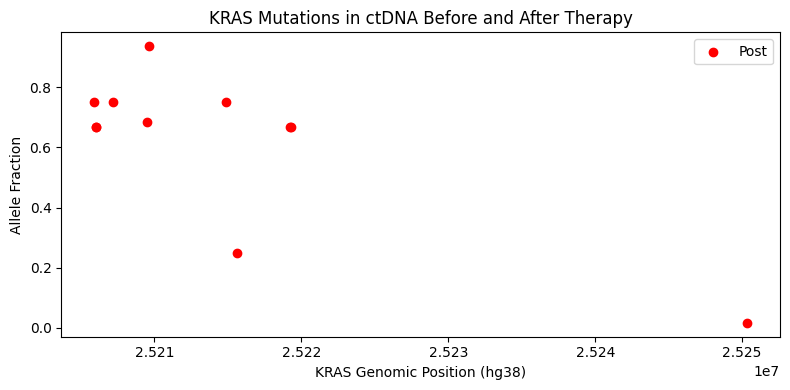

In [11]:
if kras_all.empty:
    print("No KRAS variants for scatter plot.")
else:
    plt.figure(figsize=(8,4))

    pre_df  = kras_all[kras_all["source"]=="pre"]
    post_df = kras_all[kras_all["source"]=="post"]

    if not pre_df.empty:
        plt.scatter(pre_df["pos"], pre_df["af"], color="blue", label="Pre")
    if not post_df.empty:
        plt.scatter(post_df["pos"], post_df["af"], color="red", label="Post")

    plt.xlabel("KRAS Genomic Position (hg38)")
    plt.ylabel("Allele Fraction")
    plt.title("KRAS Mutations in ctDNA Before and After Therapy")
    plt.legend()
    plt.tight_layout()
    plt.show()


**Figure: KRAS mutations across the genomic locus in post treatment ctDNA.**  
Each point represents a KRAS mutation in the post treatment ctDNA sample, plotted by genomic position on the x axis and allele fraction on the y axis. All points come from the post treatment sample, confirming the absence of KRAS mutations at baseline. The cluster of high allele fraction mutations across the locus reflects expansion of KRAS driven resistant subclones under treatment pressure.


## Interpretation of KRAS Variant Dynamics Based on Visualizations

The two visualizations shown above will give a clear, consistent picture of how KRAS mutations changed between the pre-treatment and post-treatment ctDNA samples for patient CTC347.

### 1. KRAS Variant Allele Fraction Bar Plot
The bar plot shows that **all detected KRAS variants are present exclusively in the post-treatment sample**.  
There are **no blue “Pre” bars**, meaning **no KRAS mutations were detected before treatment**.

In contrast, the orange “Post” bars reach **high allele fractions**, with several variants between **0.65 and 0.95**.  
Such high AF values indicate that these KRAS-mutant clones make up a **large proportion of the circulating tumor DNA** after therapy.

One variant shows a low AF (~0.02), suggesting a minor emerging subclone, but the majority are strong, high-confidence expansions.

### 2. KRAS Genomic Position Scatter Plot
The scatter plot places these mutations along the KRAS genomic region (hg38).  
Again, **only post-treatment points appear**, it confirms that **KRAS mutations were completely absent before therapy**.

Most points cluster tightly between **25.20–25.22**, showing multiple independent mutations arising within the gene.  
Allele fractions remain high across the region, reinforcing the idea that **KRAS-mutant subclones became dominant**.

### Overall Interpretation

Together, these plots show a textbook example of **therapy-driven clonal selection**:

- **Before treatment:** the tumor is KRAS-wildtype (no KRAS mutations detected).  
- **After EGFR-targeted therapy:** multiple **KRAS-mutant resistant clones emerge and expand**, as seen by high post-treatment allele fractions.

This pattern is expected in metastatic colorectal cancer patients treated with anti-EGFR therapy.  
KRAS mutations are a well-known mechanism of resistance; under selective pressure, small KRAS-positive subclones gain a survival advantage and rapidly expand.

**In summary:**  
The visual evidence strongly supports that **KRAS-driven resistant subclones emerged only after therapy**, ultimately dominating the ctDNA landscape.  
This aligns perfectly with known resistance biology and demonstrates how ctDNA captures real-time tumor evolution.
